In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

tf.__version__
tf.keras.__version__

TensorFlow Version: 2.3.0
Default GPU Device: /device:GPU:0


'2.4.0'

In [2]:
# library
import pandas as pd
import os 
import feather
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from utils import *

In [3]:
# read in 
WU = feather.read_dataframe('Data/WU.feather')
WU2 = WU
#pp
WU = WU.drop(columns=['Index','year','ParcelID','Days','year','month'])

WU_train = WU[WU['Set'] == 'train'].drop(columns=['Set'])
WU_dev = WU[WU['Set'] == 'dev'].drop(columns=['Set'])
WU_test = WU[WU['Set'] == 'test'].drop(columns=['Set'])

WU_train_all =  WU[WU['Set'] != 'test'].drop(columns=['Set'])

predictors = list( WU_train.drop(columns=['TotalWaterUse']).columns)

X_train1 = WU_train.drop(columns=['TotalWaterUse']).values
Y_train = WU_train.loc[:,'TotalWaterUse'].values

X_dev1 = WU_dev.drop(columns=['TotalWaterUse']).values
Y_dev = WU_dev.loc[:,'TotalWaterUse'].values

X_test1 = WU_test.drop(columns=['TotalWaterUse']).values
Y_test = WU_test.loc[:,'TotalWaterUse'].values

X_train_all1 = WU_train_all.drop(columns=['TotalWaterUse']).values
Y_train_all = WU_train_all.loc[:,'TotalWaterUse'].values

p_scalar1 = preprocessing.StandardScaler() # for dev
p_scalar2 = preprocessing.StandardScaler() # for test
p_scalar1.fit(X_train1)
p_scalar2.fit(X_train_all1)

X_train = p_scalar1.transform(X_train1 )
X_dev = p_scalar1.transform(X_dev1)

X_train_all = p_scalar2.transform(X_train_all1)
X_test = p_scalar2.transform(X_test1 )

# Fit dev

In [4]:
from tensorflow import keras
from sklearn.metrics import mean_squared_error


del model
tf.keras.backend.clear_session()

In [5]:
def buildmodel(dense_dp = 0, l2=0.01, unites =128):
    model = keras.models.Sequential([
        
        keras.layers.Dense(unites,activation='selu', 
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu', 
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),

        keras.layers.Dense(1,activation='relu')
    ])
    return model

In [6]:
# graph
l2=0
unites = 64
dp=0
lr=1e-3
batch_size=256

In [7]:
B_mu = buildmodel(dense_dp=dp,l2=l2,unites=unites)
B_sig = buildmodel(dense_dp=dp,l2=l2,unites=unites)

Input_ = keras.Input(shape =  X_train.shape[1:])
Out_mu = B_mu(Input_)
Out_sig = B_sig(Input_)
Output_ =  keras.layers.Concatenate(axis=-1)([Out_mu,Out_sig])
model = keras.Model(inputs=[Input_],outputs=[Output_] )

In [8]:
# obj
def gaussian_nll(y_true, y_pred):
    n_dims = 1
    mu = y_pred[:, 0:n_dims]
    log_sig = y_pred[:, n_dims:]
    y_diff = tf.math.subtract(y_true, mu)
    n = y_pred.shape[0]
    pi = tf.constant(np.full(fill_value= np.pi, shape=n), dtype=tf.float32)
    
    NLL = 0.5*tf.math.log(2*pi) + log_sig + 0.5*tf.math.square(y_diff)*tf.math.exp(-2*log_sig)
    
    return NLL

In [9]:
# metric
def gaussian_nll_metric(y_true, y_pred):
    NLL = tf.reduce_mean(gaussian_nll(y_true, y_pred))
    return NLL

In [10]:
model.compile(optimizer = keras.optimizers.Nadam(learning_rate=lr), loss = gaussian_nll, metrics = [gaussian_nll_metric] )

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1)            38465       input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            38465       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           sequential[0][0]                 
                                                                 sequential_1[0][0]    

In [12]:
callback_list =[
    keras.callbacks.EarlyStopping(
        monitor = 'val_gaussian_nll_metric',
        restore_best_weights=True,
        patience= 5
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='MLP_log/mpl_gaussian_dev_12m.h5', # modify
        save_best_only= True,
        monitor='val_gaussian_nll_metric'
    ),
    #callbacks.ReduceLROnPlateau(factor=0.5,patience=5), # eta performance scheduling
   # keras.callbacks.TensorBoard(log_dir='MLP_log',histogram_freq=1)
]

In [13]:
# seed
tf.random.set_seed(1)
np.random.seed(1)

In [14]:
history = model.fit(x= X_train,
                    y= Y_train,
                    epochs= 500,
                    batch_size= batch_size,
                    validation_data=( X_dev,Y_dev),
                    callbacks=callback_list)

Epoch 1/500
45/45 [==============================] - 1s 29ms/step - loss: 1849237.2500 - gaussian_nll_metric: 1813980.1250 - val_loss: 5285.6216 - val_gaussian_nll_metric: 5083.4014
Epoch 2/500
45/45 [==============================] - 1s 17ms/step - loss: 1850.3270 - gaussian_nll_metric: 1822.9220 - val_loss: 2102.3962 - val_gaussian_nll_metric: 2032.2448
Epoch 3/500
45/45 [==============================] - 1s 16ms/step - loss: 1072.2566 - gaussian_nll_metric: 1069.6807 - val_loss: 1374.5026 - val_gaussian_nll_metric: 1333.0209
Epoch 4/500
45/45 [==============================] - 1s 19ms/step - loss: 754.2322 - gaussian_nll_metric: 749.5991 - val_loss: 983.8622 - val_gaussian_nll_metric: 955.9468
Epoch 5/500
45/45 [==============================] - 1s 19ms/step - loss: 564.7156 - gaussian_nll_metric: 565.0734 - val_loss: 744.5059 - val_gaussian_nll_metric: 724.7719
Epoch 6/500
45/45 [==============================] - 1s 18ms/step - loss: 440.4981 - gaussian_nll_metric: 439.4070 - val_l

45/45 [==============================] - 1s 19ms/step - loss: 20.0689 - gaussian_nll_metric: 19.9944 - val_loss: 27.8266 - val_gaussian_nll_metric: 27.6305
Epoch 50/500
45/45 [==============================] - 1s 17ms/step - loss: 19.6288 - gaussian_nll_metric: 19.6352 - val_loss: 27.1148 - val_gaussian_nll_metric: 26.9305
Epoch 51/500
45/45 [==============================] - 1s 18ms/step - loss: 19.2099 - gaussian_nll_metric: 19.0974 - val_loss: 26.4121 - val_gaussian_nll_metric: 26.2368
Epoch 52/500
45/45 [==============================] - 1s 18ms/step - loss: 18.8200 - gaussian_nll_metric: 18.6996 - val_loss: 25.7568 - val_gaussian_nll_metric: 25.5914
Epoch 53/500
45/45 [==============================] - 1s 17ms/step - loss: 18.4457 - gaussian_nll_metric: 18.4326 - val_loss: 25.1466 - val_gaussian_nll_metric: 24.9907
Epoch 54/500
45/45 [==============================] - 1s 18ms/step - loss: 18.0967 - gaussian_nll_metric: 18.0549 - val_loss: 24.5577 - val_gaussian_nll_metric: 24.4101

45/45 [==============================] - 1s 21ms/step - loss: 10.9171 - gaussian_nll_metric: 10.9161 - val_loss: 11.5052 - val_gaussian_nll_metric: 11.5189
Epoch 146/500
45/45 [==============================] - 1s 21ms/step - loss: 10.9099 - gaussian_nll_metric: 10.9112 - val_loss: 11.4834 - val_gaussian_nll_metric: 11.4972
Epoch 147/500
45/45 [==============================] - 1s 19ms/step - loss: 10.9029 - gaussian_nll_metric: 10.9018 - val_loss: 11.4630 - val_gaussian_nll_metric: 11.4770
Epoch 148/500
45/45 [==============================] - 1s 20ms/step - loss: 10.8962 - gaussian_nll_metric: 10.9023 - val_loss: 11.4468 - val_gaussian_nll_metric: 11.4609
Epoch 149/500
45/45 [==============================] - 1s 20ms/step - loss: 10.8899 - gaussian_nll_metric: 10.8820 - val_loss: 11.4312 - val_gaussian_nll_metric: 11.4454
Epoch 150/500
45/45 [==============================] - 1s 19ms/step - loss: 10.8837 - gaussian_nll_metric: 10.8908 - val_loss: 11.4149 - val_gaussian_nll_metric: 11

45/45 [==============================] - 1s 17ms/step - loss: 10.5058 - gaussian_nll_metric: 10.5046 - val_loss: 10.7428 - val_gaussian_nll_metric: 10.7522
Epoch 242/500
45/45 [==============================] - 1s 18ms/step - loss: 10.5016 - gaussian_nll_metric: 10.4979 - val_loss: 10.7354 - val_gaussian_nll_metric: 10.7449
Epoch 243/500
45/45 [==============================] - 1s 22ms/step - loss: 10.4969 - gaussian_nll_metric: 10.4944 - val_loss: 10.7291 - val_gaussian_nll_metric: 10.7385
Epoch 244/500
45/45 [==============================] - 1s 23ms/step - loss: 10.4927 - gaussian_nll_metric: 10.4881 - val_loss: 10.7223 - val_gaussian_nll_metric: 10.7315
Epoch 245/500
45/45 [==============================] - 1s 24ms/step - loss: 10.4880 - gaussian_nll_metric: 10.4831 - val_loss: 10.7152 - val_gaussian_nll_metric: 10.7243
Epoch 246/500
45/45 [==============================] - 1s 22ms/step - loss: 10.4836 - gaussian_nll_metric: 10.4858 - val_loss: 10.7076 - val_gaussian_nll_metric: 10

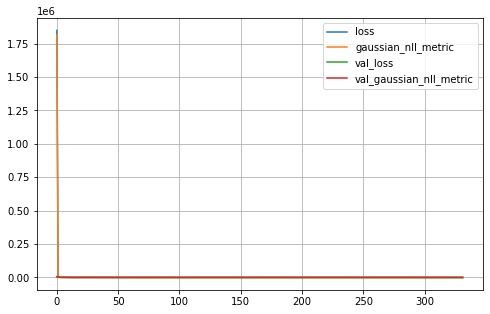

In [15]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

plt.show()

In [16]:
pred = model.predict(X_dev)
y_true = Y_dev
y = y_true
miu = pred[:,0]
log_sig_hat =pred[:,1]
pi =  np.full(fill_value= np.pi, shape=np.shape(y)[0],dtype=float)
nll = ( np.sum(0.5*np.log(2*pi) + log_sig_hat + 0.5 * ((y - miu)**2) * np.exp(-2*log_sig_hat)))/y.shape[0]
np.min(history.history.get('val_gaussian_nll_metric'))

9.63508129119873

In [17]:
stop_epoch = pd.Series(history.history['val_gaussian_nll_metric'],index = history.epoch).idxmin()

In [18]:
sig_hat = np.exp(log_sig_hat)
y_hat = miu
WU2 = feather.read_dataframe('Data/WU.feather')

MF = pd.DataFrame({
    'Index': WU2[WU2.loc[:,'Set']=='dev'].loc[:,'Index'].values,
    'Y': y_true,
    'y_hat': y_hat,
    'sig_hat': sig_hat,
    'p_y': norm.pdf(y_true,loc=y_hat,scale=sig_hat)
})

path = 'Out_dev_MF\\month12\\Probabilistic_MLP_dev_12m_dist.feather'


feather.write_dataframe(MF , path)

In [19]:

del model
tf.keras.backend.clear_session()

# Test

In [20]:
# graph

B_mu = buildmodel(dense_dp=dp,l2=l2,unites=unites)
B_sig = buildmodel(dense_dp=dp,l2=l2,unites=unites)

Input_ = keras.Input(shape =  X_train.shape[1:])
Out_mu = B_mu(Input_)
Out_sig = B_sig(Input_)
Output_ =  keras.layers.Concatenate(axis=-1)([Out_mu,Out_sig])
model = keras.Model(inputs=[Input_],outputs=[Output_] )


In [21]:
model.compile(optimizer = keras.optimizers.Nadam(learning_rate=lr), loss = gaussian_nll, metrics = [gaussian_nll_metric] )

In [22]:
# modify
callback_list =[
    #keras.callbacks.EarlyStopping(
   #     monitor = 'val_gaussian_nll_metric',
  #      restore_best_weights=True,
  #      patience= stop_epoch
  #  ),
    keras.callbacks.ModelCheckpoint(
        filepath='MLP_log/mpl_gaussian_final_12m.h5', # modify
      #  save_best_only= True,
  #      monitor='val_gaussian_nll_metric'
    ),
    #callbacks.ReduceLROnPlateau(factor=0.5,patience=5), # eta performance scheduling
   # keras.callbacks.TensorBoard(log_dir='MLP_log',histogram_freq=1)
]

In [23]:
# seed
tf.random.set_seed(1)
np.random.seed(1)


history = model.fit(x= X_train_all,
                    y= Y_train_all,
                    epochs= stop_epoch,
                    batch_size= batch_size,
                   # validation_data=( X_test,Y_test),
                    callbacks=callback_list
                   )


Epoch 1/326
49/49 [==============================] - 1s 18ms/step - loss: 897796.6875 - gaussian_nll_metric: 894655.0000
Epoch 2/326
49/49 [==============================] - 1s 17ms/step - loss: 1043.4152 - gaussian_nll_metric: 1041.7853
Epoch 3/326
49/49 [==============================] - 1s 19ms/step - loss: 647.4805 - gaussian_nll_metric: 646.5485
Epoch 4/326
49/49 [==============================] - 1s 22ms/step - loss: 469.0324 - gaussian_nll_metric: 469.0712
Epoch 5/326
49/49 [==============================] - 1s 18ms/step - loss: 354.6690 - gaussian_nll_metric: 354.0521
Epoch 6/326
49/49 [==============================] - 1s 18ms/step - loss: 279.0172 - gaussian_nll_metric: 278.4222
Epoch 7/326
49/49 [==============================] - 1s 18ms/step - loss: 224.7119 - gaussian_nll_metric: 224.7558
Epoch 8/326
49/49 [==============================] - 1s 17ms/step - loss: 185.6604 - gaussian_nll_metric: 185.4852
Epoch 9/326
49/49 [==============================] - 1s 20ms/step - loss

49/49 [==============================] - 1s 17ms/step - loss: 11.2598 - gaussian_nll_metric: 11.2606
Epoch 144/326
49/49 [==============================] - 1s 17ms/step - loss: 11.2543 - gaussian_nll_metric: 11.2556
Epoch 145/326
49/49 [==============================] - 1s 18ms/step - loss: 11.2489 - gaussian_nll_metric: 11.2499
Epoch 146/326
49/49 [==============================] - 1s 18ms/step - loss: 11.2434 - gaussian_nll_metric: 11.2426
Epoch 147/326
49/49 [==============================] - 1s 19ms/step - loss: 11.2377 - gaussian_nll_metric: 11.2395
Epoch 148/326
49/49 [==============================] - 1s 19ms/step - loss: 11.2323 - gaussian_nll_metric: 11.2314
Epoch 149/326
49/49 [==============================] - 1s 17ms/step - loss: 11.2265 - gaussian_nll_metric: 11.2287
Epoch 150/326
49/49 [==============================] - 1s 16ms/step - loss: 11.2210 - gaussian_nll_metric: 11.2205
Epoch 151/326
49/49 [==============================] - 1s 17ms/step - loss: 11.2152 - gaussian

49/49 [==============================] - 1s 18ms/step - loss: 9.5690 - gaussian_nll_metric: 9.5694
Epoch 285/326
49/49 [==============================] - 1s 20ms/step - loss: 9.5620 - gaussian_nll_metric: 9.5620
Epoch 286/326
49/49 [==============================] - 1s 18ms/step - loss: 9.5586 - gaussian_nll_metric: 9.5583
Epoch 287/326
49/49 [==============================] - 1s 18ms/step - loss: 9.5552 - gaussian_nll_metric: 9.5553
Epoch 288/326
49/49 [==============================] - 1s 21ms/step - loss: 9.5508 - gaussian_nll_metric: 9.5511
Epoch 289/326
49/49 [==============================] - 1s 19ms/step - loss: 9.5470 - gaussian_nll_metric: 9.5468
Epoch 290/326
49/49 [==============================] - 1s 21ms/step - loss: 9.5412 - gaussian_nll_metric: 9.5413
Epoch 291/326
49/49 [==============================] - 1s 17ms/step - loss: 9.5376 - gaussian_nll_metric: 9.5378
Epoch 292/326
49/49 [==============================] - 1s 19ms/step - loss: 9.5329 - gaussian_nll_metric: 9.53

In [24]:
pred = model.predict(X_test)
y_true = Y_test
y = y_true
miu = pred[:,0]
log_sig_hat =pred[:,1]
pi =  np.full(fill_value= np.pi, shape=np.shape(y)[0],dtype=float)
nll = ( np.sum(0.5*np.log(2*pi) + log_sig_hat + 0.5 * ((y - miu)**2) * np.exp(-2*log_sig_hat)))/y.shape[0]

In [25]:
zp = 1.959963984540
sig_hat = np.exp(log_sig_hat)
y_hat = miu
#LU
left = (y_hat - sig_hat*zp)
right = (y_hat + sig_hat*zp)

In [27]:
WU2 = feather.read_dataframe('Data/WU.feather')

MF= pd.DataFrame({
    'Index': WU2[WU2.loc[:,'Set']=='test'].loc[:,'Index'].values,
    'Y': y_true,
    'y_hat': y_hat,
    'sig_hat': sig_hat,
     'p_y': norm.pdf(y_true,loc=y_hat,scale=sig_hat)
})

# modify
path = 'Out_test_MF\\month12\\Probabilistic_MLP_12m_dist.feather'

feather.write_dataframe(MF , path)

# report

In [28]:
r1,r2,r3,r4,r5 = get_RMSE_NLL_NOIS_AWPI_ECPI(y_true,y_hat,left,right,alpha=0.05)

 & 3145.56 & 9.58 & 17491.89 & 12302.96 & 0.92 & 95\% \\


In [30]:
# results
with open("Results/Results_12m.txt", "a") as myfile:
    myfile.write("MLP_Pr \n")
    myfile.write('RMSE %f & NLL %f & NOIS %f & AWPI %f & ECPI %f \n' % (
        r1,r2,r3,r4,r5 ))